Price, Macro, Time Series Script

In [2]:
import numpy as np
import statsmodels.api as sm
import plotly.express as px
import plotly.figure_factory as ff
from ipywidgets import HBox, VBox
import scipy.stats as sps
from scipy.optimize import fmin, minimize
from scipy.stats import t
from scipy.stats import norm
from math import inf
import bs4 as bs
import requests
import yfinance as yf
import datetime
from scipy.stats import gamma
from scipy.stats import beta
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VAR
import numpy as np
import datetime as dt
import sqlite3
import time
import config 
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import ndtest        
from financetoolkit import Toolkit
import warnings
warnings.filterwarnings("ignore")


class Macro:
    
    """
    This class is mainly for my paper trading in spot markets. Derivatives will have a separate script. 
    """
    
    def __init__(self, condition, start, end):
        if condition == 1:
            self.period1 = start
            self.period2 = end
        else:
            self.period1 = int(time.mktime((dt.datetime.now() - dt.timedelta(365*35)).timetuple()))
            self.period2 = int(time.mktime(dt.datetime.now().timetuple()))
        
        self.fred_start = str(dt.datetime.now() - dt.timedelta(365*35)).split()[0]
        self.fred_end = dt.datetime.now()
        self.interval = '1d'
        self.symbols_list = 'THREEFF2','THREEFF10','DGS5', 'DGS10','DGS2','NASDAQCOM'
    
    def macro(self):
        symbols = []
        for ticker in self.symbols_list: 
            try:
                r = web.DataReader(ticker,'fred', self.fred_start, self.fred_end)
                r['ticker'] = ticker
                symbols.append(r)
            except:
                msg = 'Failed to read symbol: {0!r}, replacing with NaN.'
        
            final = pd.concat(symbols)
            final_df = final.reset_index()
        
        return symbols, final_df
    
    
    def ticker_filter(self, ticker, final):
        return final[final['ticker']==f"{ticker}"]
    
    def dataframe(self, tickers, final, start, end):
        
        """
        Inputs: The tickers you want to filter by and a raw unfiltered data query from trading database. 
        Outputs: A dataframe with the columns being the names of the selected tickers and the values being 
        the adjusted adjusted close prices. 
        """
        
        new_df = []
        for ticker in tickers:
            new = final[final['ticker']==f"{ticker}"]
            new_df.append(new)
        main = pd.concat(new_df)
        df = main.pivot_table(index = main.index, columns = "ticker", values = 'close')
        return df[start:end]
    
class Trading:
    
    def __init__(self, condition, start, end):
        if condition == 1:
            self.period1 = start
            self.period2 = end
        else:
            self.period1 = int(time.mktime((dt.datetime.now() - dt.timedelta(365*35)).timetuple()))
            self.period2 = int(time.mktime(dt.datetime.now().timetuple()))
        
        self.fred_start = str(dt.datetime.now() - dt.timedelta(365*35)).split()[0]
        self.fred_end = dt.datetime.now()
        self.interval = '1d'
        self.ticker_list = ["SPY",'TSN','HSY','ADM','CAG','CLX','COST','GIS','HRL','DG','K','DAR','PPC',
           'MDLZ','TAP','UL','DPZ','WMT','PEP','KR','KO','KHC','KDP','SJM','POST',
           'BG','CHD','CL','HAIN','MNST','MCD','STZ','NKE', 'THS', 'PG','LANC',
           'SMPL', 'MKC', 'QSR', 'SBUX', 'PZZA', 'WEN','BTI', 'MO', 'SYY', 'CMG', 'CPB','^TNX'] 
    
    def yahoo_universe(self):
        web3 = []
        failed = []
        for security in self.ticker_list:
            try:                                                    
                interval = '1d' 
                query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{security}?period1={self.period1}&period2={self.period2}&interval={self.interval}&events=history&includeAdjustedClose=true'
                df = pd.read_csv(query_string).set_index("Date")
                df['ticker'] = security
                df.columns = ['Open', 'High', 'Low','Close','Adj Close','Volume','ticker']
                web3.append(df)
            except:
                failed.append(security)                                                
                pass
            final = pd.concat(web3)
            df_final = final.reset_index()
        return df_final, web3, failed

    
    def trading_sql(self, data_file):
        try:
            conn = sqlite3.connect('tradable_universe') 
            data_file.to_sql("consensusinvestable", conn, if_exists='replace', index = False)
            conn.commit()
            conn.close()
            print("Updating the sql table was a success")
        except:
            print("Was unsuccessful in uploading the dataframe into the datatable. ")
    
    
    def to_trading_sql(self, data):
        
        """
        Inputs: dataframe you want to upload
        Outputs: saves SQL table to the investable database 
        """
        
        try:
            connection = sqlite3.connect(config.db_file)
            data.to_sql("consensusinvestable", connection, if_exists='replace', index=False)
            connection.commit()
            connection.close()
            print("Uploading dataframe to database worked successfully.")
        except:
            print("Was unable to save the dataframe into the investable datatable.")

    
    def load_sql(self):
        try:
            conn = sqlite3.connect('tradable_universe') 
            df = pd.read_sql_query("SELECT * from consensusinvestable", conn)
            conn.commit()
            conn.close()
        except:
            print("Could not retrieve the datatable. ")
        return df
    
    
    def ticker_filter(self, ticker, final):
        return final[final['ticker']==f"{ticker}"]
    
    
    def dataframe(self, tickers, final, start, end):
        
        """
        Inputs: The tickers you want to filter by and a raw unfiltered data query from trading database. 
        Outputs: A dataframe with the columns being the names of the selected tickers and the values being 
        the adjusted adjusted close prices. 
        """
        
        new_df = []
        for ticker in tickers:
            new = final[final['ticker']==f"{ticker}"]
            new_df.append(new)
        main = pd.concat(new_df)
        df = main.pivot_table(index = main.index, columns = "ticker", values = 'Adj Close')
        return df[start:end]
    
class TimeSeries:

    def __init__(self, data_df):
        self.data_df = data_df
    
    def parse_pair(self, pair):
        s1 = pair[:pair.find('-')]
        s2 = pair[pair.find('-')+1:]
        return s1,s2

    def show_pairs(self, results):
        selected_stocks = []     # creating empty lists for the stocks
        selected_pairs = []      # creating an empty list for the identified higher correlated pairs. 

        for pair in results.sort_values(by='tau', ascending=False).index:
            s1,s2 = self.parse_pair(pair)         # selecting the pairs
            if (s1 not in selected_stocks) and (s2 not in selected_stocks):
                selected_stocks.append(s1)   # adding the first pair 
                selected_stocks.append(s2)   # adding the second pair 
                selected_pairs.append(pair)  # adding pairs to selected pairs list => stops after 20

            if len(selected_pairs) == 50:    # selecting 50 pairs with the highest Kendall's rank correlation
                break

        return selected_stocks, selected_pairs 

    def kendall(self, df):
        """
        Inputs: dataframe with all the raw price data (df.set_index("Date")), train_start is the date in string form
        of the training dataset (as is train_end, test_start, and test end)
        Outputs: training data kendall tau's
        """
        returns = np.log(df).diff().dropna()
        results = pd.DataFrame(columns=['tau'])

        for s1 in returns.columns:
            for s2 in returns.columns:
                if (s1!=s2) and (f'{s2}-{s1}' not in results.index):
                    results.loc[f'{s1}-{s2}'] = stats.kendalltau(returns[s1], returns[s2])[0]

        return results
    
    def gaussian_dist_fit(self, dataW, target):
        returns = np.sort(dataW[target])
        edf = np.arange(1,len(returns)+1)/len(returns)
        mean = np.average(returns)
        std = np.std(returns)
        normal_cdf = sps.norm.cdf(returns, mean, std)
        plt.plot(returns, edf)
        plt.plot(returns, normal_cdf)
        plt.show()
        p_value = np.exp(-len(returns)*max(abs(edf-normal_cdf))**2)
        if p_value < 0.1:
            print(f'{target} does not fit the normal distribution well: P-Value: {round(p_value,2)}')
        else:
            print(f'{target} fits the normal distribution well: P-Value: {round(p_value,2)}')

    def kpss_test(self):
        test_stat, p_val = [], []
        cv_1pct, cv_2p5pct, cv_5pct, cv_10pct = [], [], [], []
        for c in self.data_df.columns: 
            kpss_res = kpss(self.data_df[c].dropna(), regression='ct')
            test_stat.append(kpss_res[0])
            p_val.append(kpss_res[1])
            cv_1pct.append(kpss_res[3]['1%'])
            cv_2p5pct.append(kpss_res[3]['2.5%'])
            cv_5pct.append(kpss_res[3]['5%'])
            cv_10pct.append(kpss_res[3]['10%'])
        kpss_res_df = pd.DataFrame({'Test statistic': test_stat, 
                                   'p-value': p_val, 
                                   'Critical value - 1%': cv_1pct,
                                   'Critical value - 2.5%': cv_2p5pct,
                                   'Critical value - 5%': cv_5pct,
                                   'Critical value - 10%': cv_10pct}, 
                                 index=self.data_df.columns).T
        kpss_res_df = kpss_res_df.round(4)
        return kpss_res_df


    def adf_test(self):
        test_stat, p_val = [], []
        cv_1pct, cv_5pct, cv_10pct = [], [], []
        for c in self.data_df.columns: 
            adf_res = adfuller(self.data_df[c].dropna())
            test_stat.append(adf_res[0])
            p_val.append(adf_res[1])
            cv_1pct.append(adf_res[4]['1%'])
            cv_5pct.append(adf_res[4]['5%'])
            cv_10pct.append(adf_res[4]['10%'])
        adf_res_df = pd.DataFrame({'Test statistic': test_stat, 
                                   'p-value': p_val, 
                                   'Critical value - 1%': cv_1pct,
                                   'Critical value - 5%': cv_5pct,
                                   'Critical value - 10%': cv_10pct}, 
                                 index=self.data_df.columns).T
        adf_res_df = adf_res_df.round(4)
        return adf_res_df

    def splitter(self):
        end = round(len(self.data_df)*.8)
        train_df = self.data_df[:end]
        test_df = self.data_df[end:]
        return train_df, test_df
    
    def select_p(self, train_df):
        aic, bic, fpe, hqic = [], [], [], []
        model = VAR(train_df) 
        p = np.arange(1,60)
        for i in p:
            result = model.fit(i)
            aic.append(result.aic)
            bic.append(result.bic)
            fpe.append(result.fpe)
            hqic.append(result.hqic)
        lags_metrics_df = pd.DataFrame({'AIC': aic, 
                                        'BIC': bic, 
                                        'HQIC': hqic,
                                        'FPE': fpe}, 
                                       index=p)    
        fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharex=True)
        lags_metrics_df.plot(subplots=True, ax=ax, marker='o')
        plt.tight_layout()
        print(lags_metrics_df.idxmin(axis=0))
        
    def granger_causation_matrix(self, data, variables, p, test = 'ssr_chi2test', verbose=False):    
        df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
        for c in df.columns:
            for r in df.index:
                test_result = grangercausalitytests(data[[r, c]], p, verbose=False)
                p_values = [round(test_result[i+1][0][test][1],4) for i in range(p)]
                if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
                min_p_value = np.min(p_values)
                df.loc[r, c] = min_p_value
        df.columns = [var + '_x' for var in variables]
        df.index = [var + '_y' for var in variables]
        return df
    
class Strategy:
    def __init_(self):
         self.start_date = '2000-01-01'   
    
    def fundamentals(self, ticker, base_url, data_type, API_KEY):   
        url = f'{base_url}/v3/{data_type}/{ticker}?period=quarter&limit=400&apikey={API_KEY}'
        response = requests.get(url)
        data = response.json()
        return pd.DataFrame(data)

    def fundamental_data(self, base_url, tickers):
        try:
            dataframe = []
            for ticker in tickers:
                data_type = ['income-statement','balance-sheet-statement','cash-flow-statement']
                inc = self.fundamentals(ticker, base_url, data_type[0], API_KEY)
                inc = inc.set_index('date')
                bs = self.fundamentals(ticker, base_url, data_type[1], API_KEY)
                bs = bs.set_index('date')
                bs = bs.add_suffix('_bs')
                cf = self.fundamentals(ticker, base_url, data_type[2], API_KEY)
                cf = cf.set_index('date')
                cf = cf.add_suffix('_cf')
                df = pd.concat([inc, bs, cf],axis=1)

                df['workingCapRatio'] = (df['totalCurrentAssets_bs'] - df['totalCurrentLiabilities_bs']) / df['totalAssets_bs']
                df['reinvestToAssets'] = df['retainedEarnings_bs'] / df['totalAssets_bs']
                df['operatingEarningsToAssets'] = (df['ebitda'] - df['depreciationAndAmortization']) / df['totalAssets_bs']
                df['leverage'] = df['totalEquity_bs'] / df['totalLiabilities_bs']
                df['assetTurnover'] = df['revenue'] / df['totalAssets_bs']
                df['Altman Z-Score'] = 1.2 * df['workingCapRatio'] + 1.4 * df['reinvestToAssets'] + 3.3 * df['operatingEarningsToAssets'] + 0.6 * df['leverage'] + 1.0 * df['assetTurnover']

                df = df.reset_index().set_index('fillingDate')
                # df.index = pd.to_datetime(df.index)
                dataframe.append(df)
        except:
            pass
        return pd.concat(dataframe)

    def factor_signal_generation(self,fund_final1, target_metric):
        final_fund_data = []
        for company1 in fund_final1.symbol.unique():
            df12 = fund_final1.loc[fund_final1.symbol == company1]
            df12 = df12.set_index('fillingDate')
            df12['target_growth_metric'] = 100 * (df12[target_metric]/df12[target_metric].shift(4)-1)
            df12 = df12.pivot_table(index = 'fillingDate',columns='symbol',values='target_growth_metric')
            final_fund_data.append(df12)
        final_fund_data1 = pd.concat(final_fund_data).sort_index().fillna(method='ffill')
        start = '2009'
        end = '2023-10-30'
        final_fund_data1 = final_fund_data1.loc[start:end]
        final_fund_data1 = final_fund_data1.dropna(axis=1).dropna()
        final_fund_data1.index = pd.to_datetime(final_fund_data1.index)
        final_fund_data1.replace([np.inf, -np.inf], 0, inplace=True)
        return final_fund_data1

    def fundamental_momentum(self,prices, fundamental_data, hold_days, take_amount, short_bool):
        hold_returns = prices.pct_change(hold_days).shift(-hold_days)
        fundamental_rank = fundamental_data.rank(axis=1)
        n = len(fundamental_rank.columns)
        def signal(rank):
            signal = np.where(rank > n*take_amount, 1, np.nan)
            short = 1-take_amount
            signal = np.where(rank < n*short, short_bool, signal)
            return signal
        trading_signal = fundamental_rank.apply(signal, axis=0)
        return hold_returns, trading_signal


    def calculate_performance(self,hold_returns, trading_signal, hold_days):
        stocks_returns = hold_returns * trading_signal
        stocks_returns = stocks_returns[::hold_days]
        trading_signal = trading_signal[::hold_days]
        trading_signal = trading_signal.replace(np.nan, 0)
        cost = (0.001 * np.abs(trading_signal - trading_signal.shift(1)))
        stocks_returns = stocks_returns - cost
        portfolio_returns = stocks_returns.mean(axis=1)
        cum_rets = (portfolio_returns+1).cumprod().dropna()
        total_portfolio_returns = (cum_rets.iloc[-1]-1)*100
        print("Portfolio Returns: %.2f" % total_portfolio_returns)
        sharpe = np.mean(portfolio_returns) / \
            np.std(portfolio_returns)*((252/hold_days)**0.5)
        print('Sharpe Ratio: %.2f' % sharpe)
        fig = plt.figure(figsize=(16, 7))
        sub = fig.add_subplot(1, 2, 1)
        cum_rets.plot()
        sub.set_ylabel('Strategy Returns', fontsize=12)
        sub.set_ylabel('Date', fontsize=12)
        running_max = np.maximum.accumulate(cum_rets.dropna())
        running_max[running_max < 1] = 1
        drawdown = ((cum_rets)/running_max - 1)
        sub = fig.add_subplot(1, 2, 2)
        drawdown.plot(color='r')
        plt.fill_between(drawdown.index, drawdown.values, color='red')
        plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
        sub.set_ylabel('Returns', fontsize=12)
        plt.show()

Fundamental Data

In [3]:
strat = Strategy()
tickers = ['TSN','HSY','ADM','CAG','CLX','COST','GIS','HRL','DG','K','DAR','PPC',
           'MDLZ','TAP','UL','DPZ','WMT','PEP','KR','KO','KHC','KDP','SJM','POST',
           'BG','CHD','CL','HAIN','MNST','MCD','STZ','NKE', 'THS', 'PG','LANC',
           'SMPL', 'MKC', 'QSR', 'SBUX', 'PZZA', 'WEN','BTI', 'MO', 'SYY', 'CMG', 'CPB']
base_url = 'https://financialmodelingprep.com/api'

fund = strat.fundamental_data(base_url, tickers)
main1 = fund.dropna().sort_index()
comps = main1.symbol.unique()
main = Trading(0, "2018-01-01", "2020-01-01")         # set first input to one if you want exact date inputs
df, df1, df2 = main.yahoo_universe()                  # dont have to run this everytime
main.trading_sql(df)                                  # placing the data into my sql datatable => consensusinvestable

Updating the sql table was a success


Price Data for Market Cap

In [4]:
pd.set_option('display.max_columns',None)
cap = df.set_index("Date")[['Adj Close','ticker']]
cap = cap[cap['ticker'].isin(comps)]
cap1 = cap.rename(columns = {'ticker':'symbol'})
cap1.index.names = ['fillingDate']
fund_final = pd.merge(main1, cap1, on=['fillingDate','symbol'], how='left').dropna()
fund_final['marketCap'] = fund_final['weightedAverageShsOutDil'] * fund_final['Adj Close']
fund_final['fcfYield'] = fund_final['freeCashFlow_cf'] / fund_final['marketCap']
fund_final['EBITDA Margin'] = (fund_final['ebitda'] / fund_final['revenue']) * 100
fund_final['ROE'] = (fund_final['netIncome'] / fund_final['totalEquity_bs']) * 100 
fund_final['currentRatio'] = fund_final['totalCurrentAssets_bs'] / fund_final['totalCurrentLiabilities_bs']
fund_final['quickRatio'] = (fund_final['totalCurrentAssets_bs'] - fund_final['inventory_bs']) / fund_final['totalCurrentLiabilities_bs']
fund_final['debtToEquityRatio'] = fund_final['totalLiabilities_bs'] / fund_final['totalEquity_bs']
fund_final['profitMargin'] = (fund_final['grossProfit'] / fund_final['revenue']) * 100  
fund_final['operatingMargin'] = (fund_final['operatingIncome'] / fund_final['revenue']) * 100  
fund_final['netProfitMargin'] = (fund_final['netIncome'] / fund_final['revenue']) * 100  
fund_final['taxRate'] = fund_final["incomeTaxExpense"] / fund_final["incomeBeforeTax"]
fund_final['nopat'] = fund_final['operatingIncome'] * (1 - fund_final['taxRate'])
fund_final['ebitdaYield'] = fund_final['ebitda'] / fund_final['marketCap']
fund_final['debtEquityRatio'] = (fund_final['shortTermDebt_bs'] + fund_final['longTermDebt_bs']) / fund_final['totalEquity_bs']
fund_final['operatingMargin'] = (fund_final['operatingIncome'] / fund_final['revenue'])*100
fund_final['fcfToDebtRatio'] = (fund_final['freeCashFlow_cf']) / fund_final['totalDebt_bs']
fund_final = fund_final[['symbol','revenue', 'costOfRevenue', 'grossProfit','ebitdaYield','fcfYield','Altman Z-Score','nopat','fcfToDebtRatio','netProfitMargin']]

Price Data for Backtest

In [5]:
final = main.load_sql().set_index("Date")
lst = list(comps)
start = '2000-01-01'
end = '2019-12-31'
dfcap = main.dataframe(lst, final, start, end)
dfcap.index.names = ["fillingDate"]

FCF Yield Long Only

Portfolio Returns: 85.60
Sharpe Ratio: 1.39


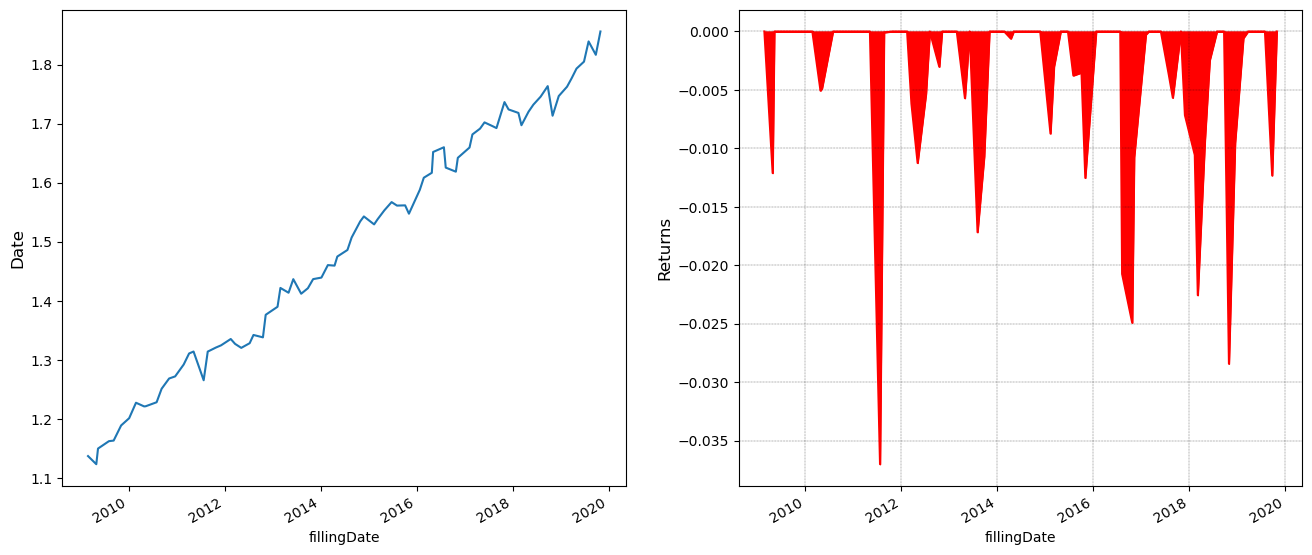

In [6]:
fund_final1 = fund_final.reset_index()
fund_final1 = fund_final1.dropna()
final_fund_data2 = strat.factor_signal_generation(fund_final1, 'fcfYield') # 'revenue', 'costOfRevenue', 'grossProfit','ebitdaYield','fcfYield','Altman Z-Score','nopat','fcfToDebtRatio','netProfitMargin'
dfcap1 = dfcap.loc[start:end,final_fund_data2.columns]
dfcap1 = dfcap1.dropna(axis=1)
dfcap1.index = pd.to_datetime(dfcap1.index)
final_fund_data2 = final_fund_data2.loc[start:end,dfcap1.columns]
prices = dfcap1.loc[final_fund_data2.index, final_fund_data2.columns]
hold_returns, trading_signal = strat.fundamental_momentum(prices, final_fund_data2, 22, .25, 0)
strat.calculate_performance(hold_returns, trading_signal, 22)
port_performance = hold_returns.dropna()
trading_signal = trading_signal[:port_performance.index[-1]]

FCF Yield LS Portfolio

Portfolio Returns: 595.42
Sharpe Ratio: 2.07


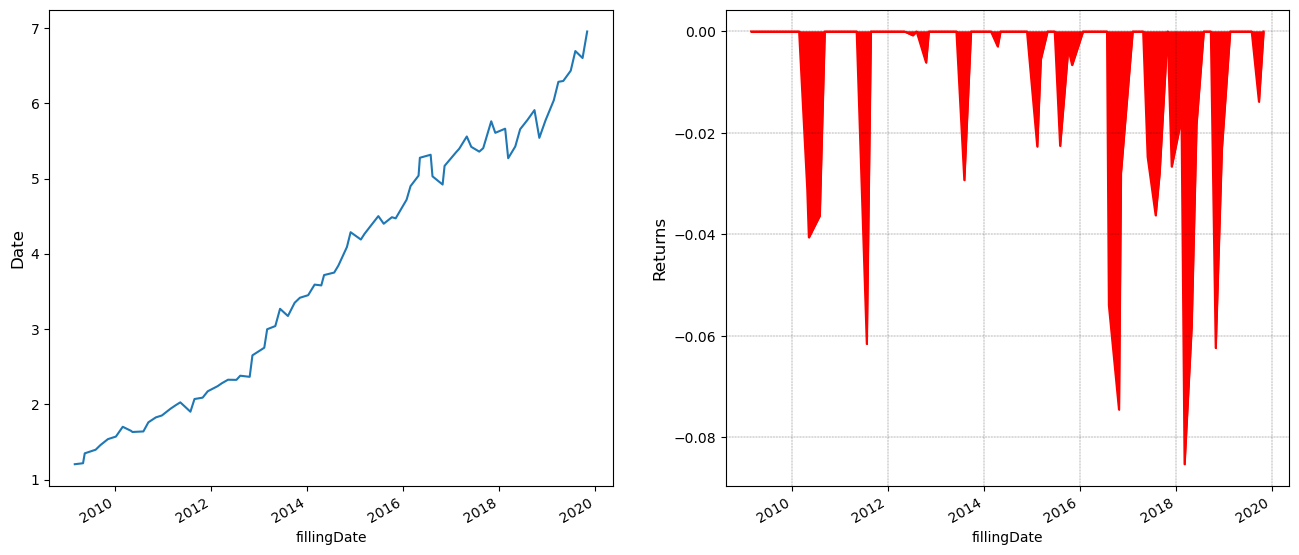

In [7]:
fund_final1 = fund_final.reset_index()
fund_final1 = fund_final1.dropna()
final_fund_data2 = strat.factor_signal_generation(fund_final1, 'fcfYield') # 'revenue', 'costOfRevenue', 'grossProfit','ebitdaYield','fcfYield','Altman Z-Score','nopat','fcfToDebtRatio','netProfitMargin'
dfcap1 = dfcap.loc[start:end,final_fund_data2.columns]
dfcap1 = dfcap1.dropna(axis=1)
dfcap1.index = pd.to_datetime(dfcap1.index)
final_fund_data2 = final_fund_data2.loc[start:end,dfcap1.columns]
prices = dfcap1.loc[final_fund_data2.index, final_fund_data2.columns]
hold_returns, trading_signal = strat.fundamental_momentum(prices, final_fund_data2, 22, .25, 1)
strat.calculate_performance(hold_returns, trading_signal, 22)
port_performance = hold_returns.dropna()
trading_signal = trading_signal[:port_performance.index[-1]]

Benchmark

Portfolio Returns: 535.69
Sharpe Ratio: 0.45


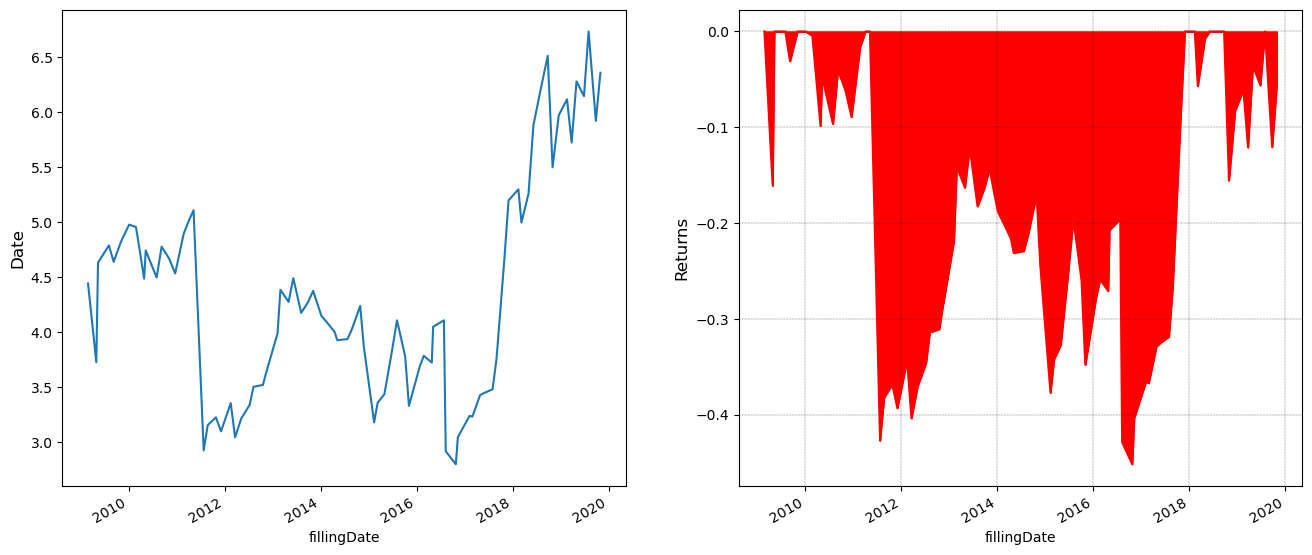

In [8]:
fund_final1 = fund_final.reset_index()
fund_final1 = fund_final1.dropna()
final_fund_data2 = strat.factor_signal_generation(fund_final1, 'fcfYield')  # 'revenue', 'costOfRevenue', 'grossProfit','ebitdaYield','fcfYield','Altman Z-Score','nopat','fcfToDebtRatio','netProfitMargin'
dfcap1 = dfcap.loc[start:end,final_fund_data2.columns]
dfcap1 = dfcap1.dropna(axis=1)
dfcap1.index = pd.to_datetime(dfcap1.index)
final_fund_data2 = final_fund_data2.loc[start:end,dfcap1.columns]
prices = dfcap1.loc[final_fund_data2.index, final_fund_data2.columns]
hold_returns, trading_signal = strat.fundamental_momentum(prices, final_fund_data2, 22, .9999, 0)
strat.calculate_performance(hold_returns, trading_signal, 22)
port_performance = hold_returns.dropna()
trading_signal = trading_signal[:port_performance.index[-1]]